# Multi-Class Classification

### Package & File Setup

In [1]:
# Python ≥3.5 is required, this cell ensures all required packages are imported and a GPU is detected (if available).
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'): # GPU detection
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os, sys
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import json
import PIL.Image
import pathlib
import pickle
import random

# To make this notebook's output stable across runs
np.random.seed(788203)
tf.random.set_seed(788203)
random.seed(788203)

In [2]:
# Main paths removed for privacy
X_train_path = r"\leftImg8bit\train/*/*.png"
X_train_extra_path = r"\leftImg8bit\train_extra/*/*.png"
Y_train_path = r"\gtFine\train/*/*.json"
Y_train_extra_path = r"\gtFine\train_extra/*/*.json"
X_train_files = glob.glob(X_train_path)
X_train_extra_files = glob.glob(X_train_extra_path)
Y_train_files = glob.glob(Y_train_path)
Y_train_extra_files = glob.glob(Y_train_extra_path)

In [3]:
# Main paths removed for privacy
X_val_path = r"\leftImg8bit\val/*/*.png"
Y_val_path = r"\gtFine\val/*/*.json"
X_val_files = glob.glob(X_val_path)
Y_val_files = glob.glob(Y_val_path)

In [18]:
# Main paths removed for privacy
X_test_path = r"\leftImg8bit\test/*/*.png"
Y_test_path = r"\gtFine\test/*/*.json"
X_test_files = glob.glob(X_test_path)
Y_test_files = glob.glob(Y_test_path)

### Data Pre-Processing

In [5]:
def ss_to_class_with_info_cars(files): # Convert cluster labels to binary label (1 for car, 0 for no car)
    y = [None] * len(files)
    total = 0
    for i in range(0, len(files)):
        with open(files[i]) as f:
            data = json.load(f)
        for j in range(0, len(data['objects'])):
            if data['objects'][j]["label"] == "car" or data['objects'][j]["label"] == "cargroup" or data['objects'][j]["label"] == "bus" or data['objects'][j]["label"] == "caravan" or data['objects'][j]["label"] == "trailer" or data['objects'][j]["label"] == "busgroup" or data['objects'][j]["label"] == "truck" or data['objects'][j]["label"] == "truckgroup": # bus
                y[i] = 1
                total += 1
                break
            y[i] = 0
    print("-------------------------")
    print(str(len(files)) + " total images.")
    print(str(total) + " images with cars.")
    print(str(len(files) - total) + " images without cars.")
    return y

In [6]:
def ss_to_class_with_info_signs(files): # Convert cluster labels to required binary label (1 for sign, 0 for no sign)
    y = [None] * len(files)
    total = 0
    for i in range(0, len(files)):
        with open(files[i]) as f:
            data = json.load(f)
        for j in range(0, len(data['objects'])):
            if data['objects'][j]["label"] == "traffic sign" or data['objects'][j]["label"] == "traffic light": # person, traffic sign
                y[i] = 1
                total += 1
                break
            y[i] = 0
    print("-------------------------")
    print(str(len(files)) + " total images.")
    print(str(total) + " images with signs.")
    print(str(len(files) - total) + " images without signs.")
    return y

In [7]:
y_train_class_cars = ss_to_class_with_info_cars(Y_train_files) # remove _cars
y_train_extra_class_cars = ss_to_class_with_info_cars(Y_train_extra_files)
y_val_class_cars = ss_to_class_with_info_cars(Y_val_files)
y_test_class_cars = ss_to_class_with_info_cars(Y_test_files)
print("-------------------------")
print(" ")
y_train_class_signs = ss_to_class_with_info_signs(Y_train_files)
y_train_extra_class_signs = ss_to_class_with_info_signs(Y_train_extra_files)
y_val_class_signs = ss_to_class_with_info_signs(Y_val_files)
y_test_class_signs = ss_to_class_with_info_signs(Y_test_files)

-------------------------
2975 total images.
2847 images with cars.
128 images without cars.
-------------------------
19998 total images.
17390 images with cars.
2608 images without cars.
-------------------------
500 total images.
482 images with cars.
18 images without cars.
-------------------------
1525 total images.
0 images with cars.
1525 images without cars.
-------------------------
 
-------------------------
2975 total images.
2845 images with signs.
130 images without signs.
-------------------------
19998 total images.
15980 images with signs.
4018 images without signs.
-------------------------
500 total images.
478 images with signs.
22 images without signs.
-------------------------
1525 total images.
0 images with signs.
1525 images without signs.


In [8]:
def datasetinfo(object1, object2): # Check number of images with multiple binary labels of 1
    object_totals = []
    count0 = 0
    count1 = 0
    count2 = 0
    for i in range(0, len(object1)):
        object_totals_element = object1[i] + object2[i]
        object_totals.append(object_totals_element)
        if object_totals[i] == 0:
            count0 += 1
        if object_totals[i] == 1:
            count1 += 1
        if object_totals[i] == 2:
            count2 += 1
    print(str(count0) + " images with none of the objects")
    print(str(count1) + " images with one of the objects")
    print(str(count2) + " images with both of the objects")
    return object_totals

In [9]:
y_train_info = datasetinfo(y_train_class_cars, y_train_class_signs)
print("-------------------------")
y_train_extra_info = datasetinfo(y_train_extra_class_cars, y_train_extra_class_signs)
print("-------------------------")
y_val_info = datasetinfo(y_val_class_cars, y_val_class_signs)
print("-------------------------")
y_test_info = datasetinfo(y_test_class_cars, y_test_class_signs) # Invalid labels

9 images with none of the objects
240 images with one of the objects
2726 images with both of the objects
-------------------------
651 images with none of the objects
5324 images with one of the objects
14023 images with both of the objects
-------------------------
3 images with none of the objects
34 images with one of the objects
463 images with both of the objects
-------------------------
1525 images with none of the objects
0 images with one of the objects
0 images with both of the objects


In [10]:
def ss_to_class(info, object1, object2): 
    dataset = []
    for i in range(0, len(info)):
        if info[i] == 0:
            dataset.append(0)
            continue
        if info[i] == 1:
            if object1[i] == 1:
                dataset.append(1)
                continue
            if object2[i] == 1:
                dataset.append(2)
                continue
        if info[i] != 0 or info[i] != 1:
            dataset.append(3) # entries with 3 will be removed eventually as they have both cars and signs.
    return dataset

In [11]:
y_train_class = ss_to_class(y_train_info, y_train_class_cars, y_train_class_signs)
y_train_extra_class = ss_to_class(y_train_extra_info, y_train_extra_class_cars, y_train_extra_class_signs)
y_val_class = ss_to_class(y_val_info, y_val_class_cars, y_val_class_signs)

In [7]:
def class_count(class_data): # Detail information about each class.
    count0 = 0
    count1 = 0
    count2 = 0
    for i in range(0, len(class_data)):
        if class_data[i] == 0:
            count0 += 1
        if class_data[i] == 1:
            count1 += 1
        if class_data[i] == 2:
            count2 += 1
    print(str(count0) + " images with nothing.")
    print(str(count1) + " images only cars.")
    print(str(count2) + " images with only traffic signs/lights.")
    print("At least " + str(len(class_data) - count0 - count1 - count2) + " images should be removed.")

In [13]:
class_count(y_train_class)
print("-------------------------")
class_count(y_train_extra_class)
print("-------------------------")
class_count(y_val_class)

9 images with nothing.
121 images only cars.
119 images with only traffic signs/lights.
At least 2726 images should be removed.
-------------------------
651 images with nothing.
3367 images only cars.
1957 images with only traffic signs/lights.
At least 14023 images should be removed.
-------------------------
3 images with nothing.
19 images only cars.
15 images with only traffic signs/lights.
At least 463 images should be removed.


### Data Creation

In [5]:
IMG_SIZE = 196 # Scale down images to (IMG_SIZE x IMG_SIZE)

In [15]:
def create_data(X_files, y_class): # Apply flipping transformation for some images.
    output_data = []
    for i in range(0, len(X_files)):
        img_array = cv2.imread(X_files[i])
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        if y_class[i] == 0:
            output_data.append([new_array, 0])
            new_array_flipped = cv2.flip(new_array, 1)  # Reflect images for more data
            output_data.append([new_array_flipped, 0]) # Add reflected data
        if y_class[i] == 1:
            output_data.append([new_array, 1])
        if y_class[i] == 2:
            output_data.append([new_array, 2])
        if y_class[i] == 3:
            output_data.append([new_array, 3]) # These images will be removed later.
        if i % 400 == 0: # Simple progress monitor (this process takes a long time)
            print(str(i) + "/" + str(len(X_files)))
    return output_data

In [16]:
training_data = create_data(X_train_files, y_train_class)
print("Training data created")
training_extra_data = create_data(X_train_extra_files, y_train_extra_class)
print("Training data (extra) created")
val_data = create_data(X_val_files, y_val_class)
print("Validation data created")

0/2975
400/2975
800/2975
1200/2975
1600/2975
2000/2975
2400/2975
2800/2975
Training data created
0/19998
400/19998
800/19998
1200/19998
1600/19998
2000/19998
2400/19998
2800/19998
3200/19998
3600/19998
4000/19998
4400/19998
4800/19998
5200/19998
5600/19998
6000/19998
6400/19998
6800/19998
7200/19998
7600/19998
8000/19998
8400/19998
8800/19998
9200/19998
9600/19998
10000/19998
10400/19998
10800/19998
11200/19998
11600/19998
12000/19998
12400/19998
12800/19998
13200/19998
13600/19998
14000/19998
14400/19998
14800/19998
15200/19998
15600/19998
16000/19998
16400/19998
16800/19998
17200/19998
17600/19998
18000/19998
18400/19998
18800/19998
19200/19998
19600/19998
Training data (extra) created
0/500
400/500
Validation data created


### Save Data

In [17]:
pickle_out = open("training_data_multiclass.pickle", "wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()

pickle_out = open("training_extra_data_multiclass.pickle", "wb")
pickle.dump(training_extra_data, pickle_out)
pickle_out.close()

pickle_out = open("val_data_multiclass.pickle", "wb")
pickle.dump(val_data, pickle_out)
pickle_out.close()

### Load Data

In [18]:
training_data = pickle.load(open("training_data_multiclass.pickle", "rb"))
training_extra_data = pickle.load(open("training_extra_data_multiclass.pickle", "rb"))
val_data = pickle.load(open("val_data_multiclass.pickle", "rb"))

In [19]:
def datacheck(data): # For checking whether operations on the data have been completed correctly
    for i in range(0, len(data)):
        print(data[i][1])

In [20]:
combined_data_new = training_data + training_extra_data + val_data # Stitch together datasets for a larger more diverse dataset
combined_data_sorted = sorted(combined_data_new, key=lambda x: str(x[1])) # Sort by class to remove data so that the training set has equal quantities of no cars vs cars

In [21]:
combined_data_eq = []

for i in range(0, 6401): # To remove the "3" class
    combined_data_eq.append(combined_data_sorted[i])

In [22]:
datacheck(combined_data_eq)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [23]:
# Remove data not needed to make each class have an equal number of images
combined_data_cut = []
for i in range(0, 1326): # 0 (no objects)
    combined_data_cut.append(combined_data_eq[i]) 
for i in range(1327, 1327+1326): # 1 (cars) # could be randomised
    combined_data_cut.append(combined_data_eq[i])
for i in range(4865, 4865+1326): # 2 (traffic signs) # could be randomised
    combined_data_cut.append(combined_data_eq[i])
print(len(combined_data_cut))

3978


In [24]:
datacheck(combined_data_cut)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [25]:
combined_data = combined_data_cut
random.shuffle(combined_data)

In [26]:
datacheck(combined_data)

1
1
0
1
1
2
1
0
1
1
1
0
0
0
0
0
1
0
1
1
2
0
0
1
0
2
1
0
2
1
0
2
1
2
2
0
2
0
1
1
1
1
2
1
1
0
1
1
2
1
0
1
0
2
2
1
1
1
1
0
0
0
1
2
2
1
2
1
1
1
0
2
2
0
0
1
1
1
1
1
1
0
0
1
1
0
1
2
1
2
0
1
2
0
2
0
0
2
0
1
0
0
0
2
1
2
2
2
2
2
0
0
0
0
1
0
1
2
2
0
0
2
2
2
2
0
2
0
0
1
1
1
2
0
1
2
2
0
1
0
0
2
0
0
1
2
2
2
0
1
0
1
0
2
2
0
0
0
1
1
2
2
2
1
1
1
1
1
0
1
1
0
0
0
0
1
2
1
2
0
1
0
2
0
2
0
0
2
0
1
1
0
0
0
1
0
2
0
1
2
0
1
0
2
0
1
2
0
1
0
2
0
2
1
0
2
0
0
0
0
0
2
2
0
2
1
1
2
1
1
0
0
0
0
1
2
2
1
0
2
0
2
1
0
1
2
0
1
2
2
1
0
0
0
1
2
1
2
0
1
1
1
1
2
2
1
2
0
1
2
1
2
1
2
0
2
1
2
2
2
1
1
2
1
0
2
1
2
0
0
0
2
1
2
1
1
0
0
1
2
1
0
2
0
2
2
0
1
2
2
2
1
1
0
2
1
0
0
0
2
1
0
0
0
2
1
1
2
0
0
1
1
0
2
0
0
0
1
2
1
0
1
2
2
1
1
1
0
1
1
2
2
1
1
1
1
1
2
2
0
2
2
0
2
2
1
2
0
0
1
1
2
1
1
2
1
1
2
2
1
2
1
0
2
0
2
0
2
1
0
2
0
1
2
0
2
0
2
0
1
1
1
2
0
1
0
0
1
0
2
2
1
1
2
0
1
0
0
2
2
1
0
2
2
2
1
0
0
0
1
1
2
1
2
1
2
2
1
1
1
0
1
1
0
2
1
0
1
2
1
0
1
0
2
1
0
0
0
1
1
2
1
2
2
2
0
0
0
0
2
0
1
0
0
2
2
0
1
2
2
2
0
0
0
2
1
1
0
0
1
0
1
2
1
2
0
2
1
1
0


In [27]:
pickle_out = open("combined_data_random_multiclass.pickle", "wb") # Save randomised data
pickle.dump(combined_data, pickle_out)
pickle_out.close()

In [2]:
combined_data = pickle.load(open("combined_data_random_multiclass.pickle", "rb")) # Load randomised data

In [3]:
def makexy(data): 
    X = []
    y = []

    for features, label in data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

In [6]:
training_data = combined_data[:-500]
test_data = combined_data[-500:]
X_train, y_train = makexy(training_data)
X_test, y_test = makexy(test_data)

### Create Initial Model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

X_train_norm = X_train/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

In [36]:
model.fit(X_train_norm, y_train, batch_size=32, epochs=10, validation_split=0.2) # validation_split=0.2 or validation_data = (X_val, y_val)

Epoch 1/10
87/87 [==============================] - 15s 107ms/step - loss: 1.0871 - accuracy: 0.4342 - val_loss: 1.0363 - val_accuracy: 0.4727
Epoch 2/10
87/87 [==============================] - 7s 75ms/step - loss: 0.9961 - accuracy: 0.5248 - val_loss: 1.0054 - val_accuracy: 0.4727
Epoch 3/10
87/87 [==============================] - 7s 76ms/step - loss: 0.9337 - accuracy: 0.5715 - val_loss: 0.9352 - val_accuracy: 0.5589
Epoch 4/10
87/87 [==============================] - 7s 76ms/step - loss: 0.8742 - accuracy: 0.6028 - val_loss: 0.8895 - val_accuracy: 0.6020
Epoch 5/10
87/87 [==============================] - 7s 76ms/step - loss: 0.8169 - accuracy: 0.6510 - val_loss: 0.8389 - val_accuracy: 0.6351
Epoch 6/10
87/87 [==============================] - 7s 76ms/step - loss: 0.7679 - accuracy: 0.6833 - val_loss: 0.8394 - val_accuracy: 0.6264
Epoch 7/10
87/87 [==============================] - 7s 76ms/step - loss: 0.7402 - accuracy: 0.6894 - val_loss: 0.7969 - val_accuracy: 0.6566
Epoch 8/10


### Tweak Model

In [1]:
# This code initialises all required packages, variables and seeds for when resetting kernel and tweaking model.
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'): # GPU detection
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os, sys
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import json
import PIL.Image
import pathlib
import pickle
import random
from tensorflow import keras as K

# To make this notebook's output stable across runs 
np.random.seed(788203)
tf.random.set_seed(788203)
random.seed(788203)

X_test_path = r"D:\Datasets\leftImg8bit\test/*/*.png"
Y_test_path = r"C:\Users\shroo\OneDrive - Nottingham Trent University\Year 4\Research Project\Python Testing\gtFine\test/*/*.json"
X_test_files = glob.glob(X_test_path)
Y_test_files = glob.glob(Y_test_path)

IMG_SIZE = 196

combined_data = pickle.load(open("combined_data_random_multiclass.pickle", "rb")) # Load randomised data

def makexy(data): 
    X = []
    y = []

    for features, label in data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

training_data = combined_data[:-500]
test_data = combined_data[-500:]
X_train, y_train = makexy(training_data)
X_test, y_test = makexy(test_data)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

X_train_norm = X_train/255.0

model = Sequential()

model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="model_input"))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (5, 5)))

model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3),  name = "visualised_layer"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(1024))
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dense(64))
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dropout(0.5)) # Added to reduce overfitting with recommended p value
model.add(Dense(3, activation = "sigmoid"))

In [3]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

In [4]:
model.fit(X_train_norm, y_train, batch_size = 32, epochs = 20, validation_split = 0.2) # no specified val data as it was combined with training data earlier.

Epoch 1/20
87/87 [==============================] - 8s 29ms/step - loss: 1.0895 - accuracy: 0.3850 - val_loss: 1.0761 - val_accuracy: 0.4454
Epoch 2/20
87/87 [==============================] - 2s 19ms/step - loss: 1.0681 - accuracy: 0.4403 - val_loss: 1.0613 - val_accuracy: 0.4224
Epoch 3/20
87/87 [==============================] - 2s 19ms/step - loss: 1.0406 - accuracy: 0.4633 - val_loss: 1.0193 - val_accuracy: 0.4813
Epoch 4/20
87/87 [==============================] - 2s 19ms/step - loss: 1.0192 - accuracy: 0.4817 - val_loss: 0.9930 - val_accuracy: 0.5086
Epoch 5/20
87/87 [==============================] - 2s 19ms/step - loss: 0.9939 - accuracy: 0.5158 - val_loss: 0.9956 - val_accuracy: 0.5172
Epoch 6/20
87/87 [==============================] - 2s 20ms/step - loss: 0.9760 - accuracy: 0.5302 - val_loss: 0.9343 - val_accuracy: 0.5891
Epoch 7/20
87/87 [==============================] - 2s 20ms/step - loss: 0.9512 - accuracy: 0.5453 - val_loss: 0.9135 - val_accuracy: 0.5589
Epoch 8/20
87

### Evaluation

In [16]:
X_test_norm = X_test/255.0
y_pred = model.predict(X_test_norm)

In [17]:
y_pred_class = []  # Convert from probabilities to "0", "1" and "2" classes
for i in range(0, len(y_pred)):
    y_pred_class.append(np.argmax(y_pred[i], axis=0))

In [7]:
for i in range(0, len(y_pred)):
    print(y_pred_class[i], y_test[i])

0 [0.]
0 [0.]
0 [2.]
1 [1.]
1 [1.]
2 [2.]
1 [2.]
0 [2.]
1 [1.]
1 [1.]
2 [1.]
2 [2.]
2 [2.]
2 [2.]
2 [0.]
2 [2.]
1 [1.]
0 [2.]
1 [1.]
2 [0.]
1 [1.]
2 [2.]
1 [1.]
0 [0.]
1 [1.]
0 [1.]
2 [1.]
1 [1.]
0 [2.]
0 [2.]
0 [1.]
2 [0.]
2 [0.]
1 [1.]
0 [0.]
2 [2.]
0 [0.]
0 [0.]
1 [1.]
0 [0.]
2 [2.]
0 [0.]
1 [1.]
1 [1.]
1 [1.]
2 [2.]
2 [2.]
1 [1.]
2 [2.]
0 [0.]
2 [2.]
0 [0.]
2 [2.]
1 [1.]
0 [0.]
2 [1.]
1 [1.]
2 [2.]
2 [2.]
2 [2.]
0 [0.]
0 [0.]
1 [1.]
1 [1.]
0 [2.]
2 [2.]
2 [1.]
1 [1.]
1 [1.]
0 [1.]
1 [1.]
2 [1.]
2 [2.]
0 [0.]
2 [1.]
0 [0.]
0 [2.]
0 [1.]
2 [1.]
0 [1.]
2 [2.]
0 [0.]
2 [0.]
2 [2.]
2 [0.]
2 [1.]
2 [1.]
2 [2.]
1 [1.]
0 [0.]
1 [2.]
0 [1.]
1 [2.]
1 [1.]
2 [2.]
2 [2.]
0 [1.]
1 [1.]
2 [2.]
1 [1.]
1 [1.]
0 [0.]
0 [2.]
1 [2.]
1 [1.]
0 [0.]
1 [1.]
1 [1.]
0 [0.]
2 [0.]
2 [0.]
0 [0.]
1 [1.]
0 [0.]
0 [0.]
0 [0.]
2 [2.]
0 [0.]
2 [2.]
0 [2.]
0 [0.]
0 [0.]
0 [1.]
2 [2.]
1 [0.]
1 [1.]
1 [1.]
0 [0.]
2 [2.]
1 [1.]
2 [2.]
2 [0.]
2 [2.]
0 [0.]
0 [0.]
2 [0.]
2 [0.]
2 [0.]
2 [1.]
1 [0.]
2 [2.]
2 [2.]
2 [1.]

In [11]:
# Print indexes of images with incorrect labels for checking purposes. 
count = 0
for i in range(0, len(y_pred_class)): # Worth talking about: image 12
    if y_pred_class[i] != y_test[i]:
        count += 1
        print(i)
print("Total incorrect labels: " + str(count) + " which is " + str(1 - (count/len(y_test))) + "% accurate")

2
6
7
10
14
17
19
25
26
28
29
30
31
32
55
64
66
69
71
74
76
77
78
79
82
84
85
86
90
91
92
96
102
103
109
110
119
122
124
131
135
136
137
138
139
142
146
147
148
152
154
155
160
162
163
172
173
179
180
181
183
185
189
192
193
194
196
204
207
209
212
217
219
220
222
224
227
229
230
232
235
237
238
239
240
241
242
244
245
246
249
250
253
257
264
265
267
271
273
278
279
281
282
284
285
291
292
294
295
296
302
308
310
313
316
327
331
332
333
334
336
339
343
344
350
357
360
362
366
367
372
373
374
377
380
386
388
390
391
396
402
404
405
407
409
412
413
421
423
428
432
434
435
441
442
447
450
455
460
463
468
469
470
471
472
475
485
486
490
494
Total incorrect labels: 170 which is 0.6599999999999999% accurate


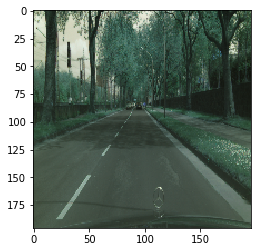

Prediction: 2   vs.   Actual: 0


In [33]:
from matplotlib import pyplot as plt
i = 31 # Index of test set to be checked. Use any number listed from output of above cell.
plt.imshow(X_test[i], interpolation='nearest')
plt.show()
print("Prediction: " + str(int(y_pred_class[i])) + "   vs.   Actual: " + str(int(y_test[i])))

### Save Model

In [12]:
model.save("MultiClass")

INFO:tensorflow:Assets written to: MultiClass\assets


### Load Model

In [19]:
model = keras.models.load_model("MultiClass") # or add the path

In [ ]:
y_pred = model.predict(X_test/255.0)

In [ ]:
y_pred_class = []  # Convert from probabilities to "0", "1" and "2" classes
for i in range(0, len(y_pred)):
    y_pred_class.append(np.argmax(y_pred[i], axis=0))

### Heatmap

In [43]:
testimg_index = 440 # Index of test set for heatmap to be generated
image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (196, 196))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0) # Apply pre-processing

func_model = model
preds = func_model.predict(image) 
pred_i = (preds > 0.5).astype("int32")
pred_i = pred_i[0][0]
print(pred_i)

1


In [44]:
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

class GradCAM: # GradCAM algorithm
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        # print(convOutputs.shape)
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

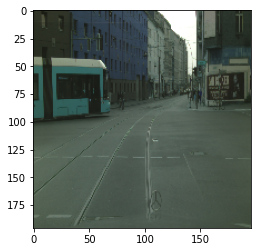

In [45]:
image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (196, 196))

# checking how it looks 
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=0)     # from 132 x 132 to 132 x 132 x 1 
image = tf.divide(image, 255)              # normalize
#image = tf.reshape(image, [1, 132, 132, 1])  # reshape to add batch dimension

In [46]:
icam = GradCAM(model, pred_i, 'visualised_layer') 

heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (196, 196))

image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (196, 196))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(196, 196) (196, 196, 3)


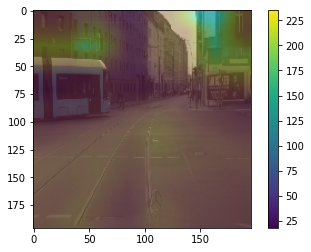

In [47]:
plt.colorbar(plt.imshow(output))
plt.show()

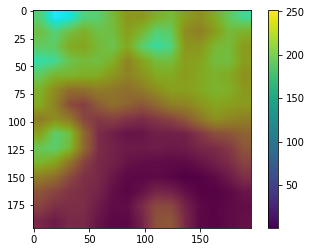

In [41]:
plt.colorbar(plt.imshow(heatmap))
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 64)      4864      
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 34, 34, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                    